In [1]:
import meshio
import numpy as np
from dolfinx import mesh, fem
from mpi4py import MPI
import basix
import pyvista as pv
from dolfinx.io import XDMFFile

[Mihirs-MBP.local:40605] shmem: mmap: an error occurred while determining whether or not /var/folders/6l/xb2bmr4d5718m4gjtrxd8h2w0000gn/T//ompi.Mihirs-MBP.501/jf.0/2582380544/sm_segment.Mihirs-MBP.501.99ec0000.0 could be created.


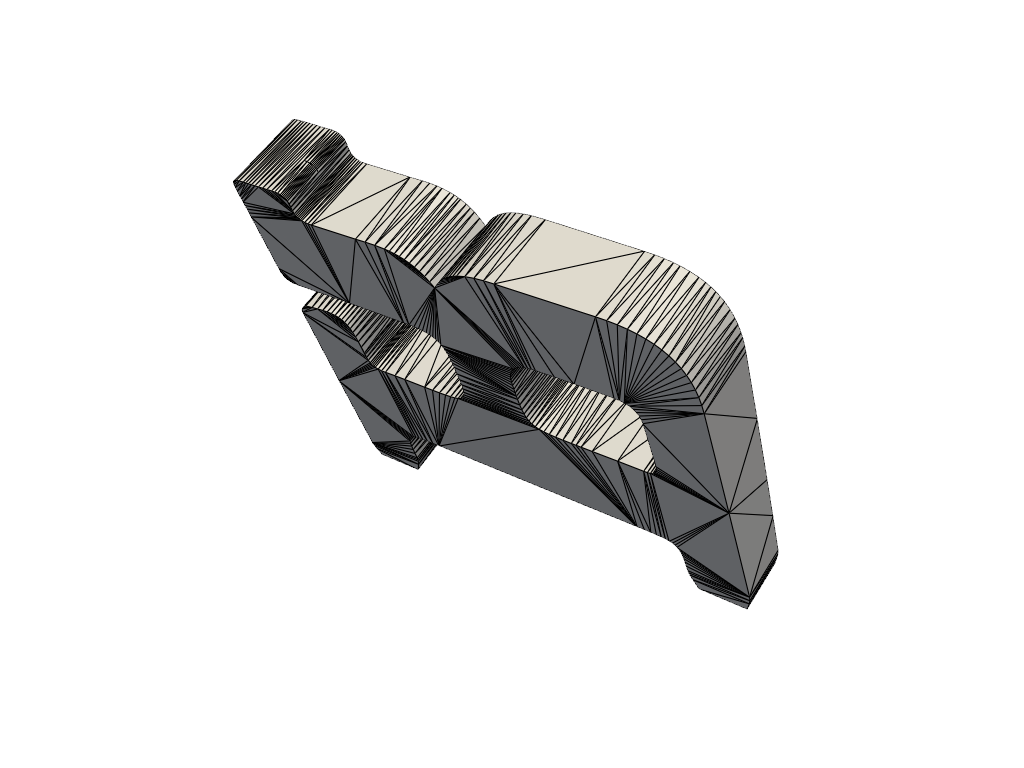

In [2]:
# Read STL
input_stl = "test.stl"
mesh_data = meshio.read(input_stl)

points = mesh_data.points
cells = mesh_data.cells_dict.get("triangle")

# PyVista
if cells is not None:
    n_cells = cells.shape[0]
    cell_data = np.hstack([np.full((n_cells, 1), 3), cells]).flatten()
else:
    raise ValueError("No triangular cells found in the mesh.")


pv_mesh = pv.PolyData(points, cell_data)
plotter = pv.Plotter()
plotter.add_mesh(pv_mesh, show_edges=True, color="white")
plotter.show()

In [3]:
# XDMF
xdmf_file = "converted_mesh.xdmf"
meshio.write(xdmf_file, mesh_data)

# Load into DOLFINx
with XDMFFile(MPI.COMM_WORLD, xdmf_file, "r") as xdmf:
    domain_mesh = xdmf.read_mesh(name="Grid")

In [4]:
# convert to lagrange element
element = basix.ufl.element(
    "Lagrange", domain_mesh.topology.cell_name(), degree=1, shape=(domain_mesh.geometry.dim,)
)

# displacement function
V = fem.functionspace(domain_mesh, element)

In [5]:
import ufl
import numpy as np
from petsc4py import PETSc

# Material properties
E = 210e9  # Young's modulus (Pa)
nu = 0.3   # Poisson's ratio

# Lame parameters
lambda_ = E * nu / ((1 + nu) * (1 - 2 * nu))
mu = E / (2 * (1 + nu))

# Define strain and stress
def epsilon(u):
    return ufl.sym(ufl.grad(u))  # Strain tensor

def sigma(u):
    return lambda_ * ufl.tr(epsilon(u)) * ufl.Identity(len(u)) + 2 * mu * epsilon(u)  # Stress tensor

# Define trial and test functions
u = ufl.TrialFunction(V)  # Dis

In [6]:
# Define trial and test functions
u = ufl.TrialFunction(V)  # Displacement field
v = ufl.TestFunction(V)

# Body force (e.g., gravity in z-direction)
f = fem.Constant(domain_mesh, PETSc.ScalarType((0.0, 0.0, -9.81)))

# Weak form
a = ufl.inner(sigma(u), epsilon(v)) * ufl.dx
L = ufl.dot(f, v) * ufl.dx 

In [7]:
# Boundary conditions
u_bc = fem.Function(V)
u_bc.interpolate(lambda x: np.zeros((domain_mesh.geometry.dim, x.shape[1])))

boundary_facets = mesh.locate_entities_boundary(
    domain_mesh, domain_mesh.topology.dim - 1, lambda x: np.isclose(x[0], 0)
)
boundary_dofs = fem.locate_dofs_topological(V, domain_mesh.topology.dim - 1, boundary_facets)
bc = fem.dirichletbc(u_bc, boundary_dofs)

In [8]:
# Solve
from dolfinx.fem.petsc import LinearProblem

problem = fem.petsc.LinearProblem(a, L, bcs=[bc])
u_sol = problem.solve()

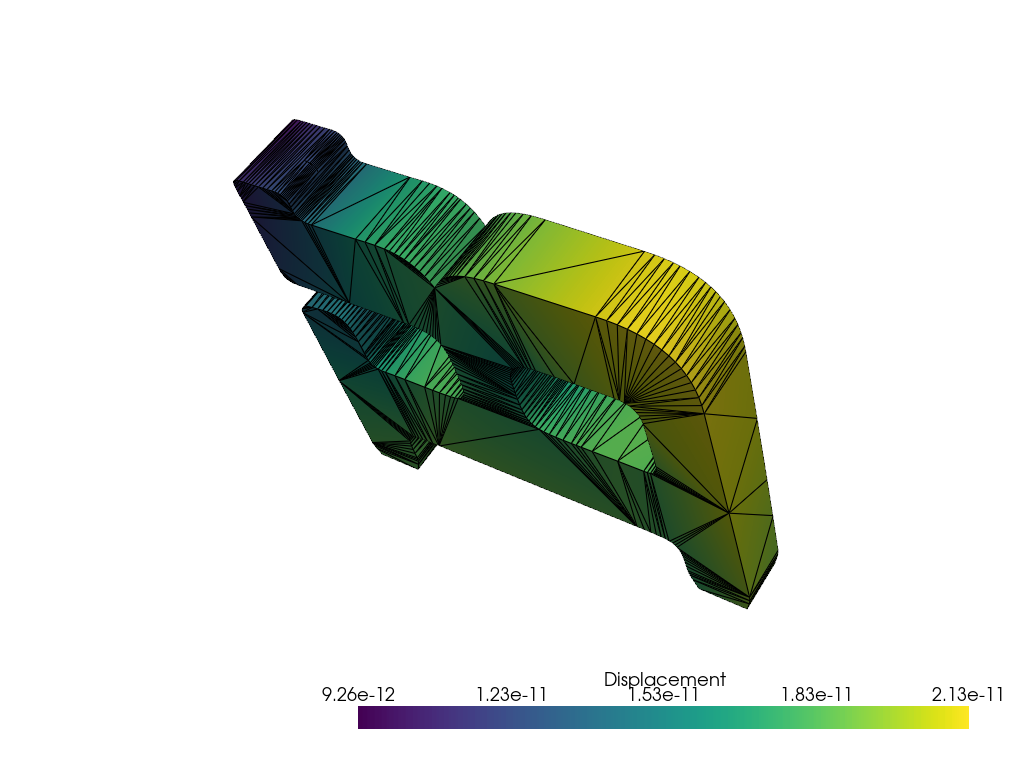

In [9]:
import pyvista as pv
from dolfinx.plot import vtk_mesh

# Visualize
topology, cell_types, geometry = vtk_mesh(domain_mesh)

grid = pv.UnstructuredGrid(topology, cell_types, geometry)

# Add displacement
grid.point_data["Displacement"] = u_sol.x.array.reshape(geometry.shape[0], -1)  # Reshape to match the mesh points

# Plot field
plotter = pv.Plotter()
plotter.add_mesh(grid, show_edges=True, scalars="Displacement", cmap="viridis")
plotter.show()